In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from fastai import *
from fastai.tabular import *
from fastai.callbacks import *
from fastai.text import *
from fastai.data_block import *
from fastai.metrics import *
from sklearn.model_selection import StratifiedKFold
from swallows.training import *
from swallows.models import *
import time
from IPython.display import FileLink, FileLinks
from swallows.plots import *

In [3]:
path=Path('data')

In [4]:
model_name = f'specialist-hw-vs-sw-ensemble-v1'

In [5]:
single_model_name = 'specialist-hw-vs-sw'

In [6]:
nlp_model_name = f'{single_model_name}-nlp-final'
nlp_encoder_name = f'{single_model_name}-tuned-enc'
tab_model_name = f'{single_model_name}-tab-final'

In [7]:
bs = 256

# Data Packaging

In [20]:
df_raw = pd.read_parquet(path/'processed/training_stage_4.parquet', engine='fastparquet')
df_train = df_raw[df_raw['root_cause'].isin(['Hardware-Issue', 'Software-Issue'])].copy()
df_train['has_offline'] = df_train['details'].str.contains('offline')

In [21]:
splits_idxs = pickle.load(open(path/f'{single_model_name}_cv_splits-10.pkl', "rb"))
split = splits_idxs[7]

In [22]:
cont_names = [] # [f'tok_{i}' for i in range(n_tok)]  #['create_to_assigned_lag_log']
exclude_from_cats = [
    'ID', 
    'assigned_date',
    'create_date',
    'details',
    'short_description',
    'amazon_domains',
    'root_cause',
    'create_to_assigned_lag'
    'create_to_assigned_lag_log',
    'assigned_date_Elapsed'
    'create_date_Elapsed',
    'details_tok'
] + cont_names

cat_names = [c for c in df_train.columns if c not in exclude_from_cats]
dep_var = 'root_cause'
procs = [FillMissing, Categorify, Normalize]

In [16]:
bs = 128 # 128 = 12502MiB (60k)
data_lm = load_data(path, f'data-lm-{single_model_name}.pkl', bs=bs)
vocab = data_lm.vocab

In [12]:
list_tab = TabularList.from_df(df_train[cat_names + cont_names + [dep_var]], cat_names=cat_names, cont_names=cont_names, procs=procs, path=path)
clas_text = pd.DataFrame({'text': df_train['details'] + ' ' +  df_train['short_description'], 'root_cause': df_train['root_cause']})
list_text = TextList.from_df(clas_text, cols='text', path=path, vocab=vocab)

#### Create mixed databunch

In [8]:
# data_text = (TextList.from_df(train_data[['details','root_cause']], cols='details', path=path, vocab=vocab)
#                 .split_by_idxs(split[0], split[1])
#                 .label_from_df(cols=dep_var)
#                 .databunch(bs=bs))
# data_text.save(f'{model_name}_data_text')

data_text = load_data(path, f'data_clas_{single_model_name}.pkl', bs=bs)

In [9]:
# data_tab = (TabularList.from_df(train_data, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
#                            .split_by_idxs(split[0], split[1])
#                            .label_from_df(cols=dep_var)
#                            .databunch(bs=bs))
# data_tab.save(f'{model_name}_data_tab')

data_tab = load_data(path, f'data_tab_{single_model_name}.pkl', bs=bs)

In [10]:
data = mixed_data_bunch(path, data_text, data_tab, bs)

# Training

#### Load models

In [11]:
def build_learner(data):
    nlp_model, nlp_layer_groups = load_nlp_backbone_pretrained(data_text, nlp_encoder_name, nlp_model_name)
    tab_model, tab_layer_groups = load_tabular_backbone(data_tab, tab_model_name)
    
    lin_layers = [nlp_model[1].layers[2].out_features + tab_model.layers[4].out_features, len(data.classes)]
    model = EnsembleModel(tab_model, nlp_model, lin_layers, drops=[0.2])
    
    layer_groups = [nn.Sequential(*(flatten_model(nlp_layer_groups[0]) + flatten_model(tab_layer_groups[0]))),
                nn.Sequential(*flatten_model(nlp_layer_groups[1])),
                nn.Sequential(*flatten_model(nlp_layer_groups[2])),
                nn.Sequential(*flatten_model(nlp_layer_groups[3])),
                nn.Sequential(*flatten_model(nlp_layer_groups[4])),
                nn.Sequential(*flatten_model(model.layers))]
    
    learn = Learner(data, model, metrics=accuracy_v2, layer_groups=layer_groups)
    return learn

#### Training

In [17]:
learn = build_learner(data)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


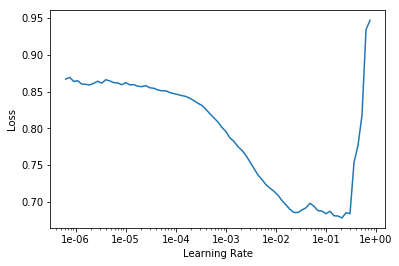

In [18]:
learn.lr_find(); learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_v2,time
0,0.418109,0.425726,0.807562,02:42


Better model found at epoch 0 with accuracy_v2 value: 0.8075622916221619.


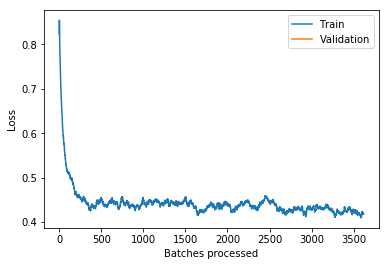

In [19]:
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy_v2', name=f'{model_name}-1')
learn.fit_one_cycle(1, 5e-3, moms=(0.8, 0.7), callbacks=callbacks); learn.recorder.plot_losses()

In [20]:
learn.freeze_to(-2)

epoch,train_loss,valid_loss,accuracy_v2,time
0,0.436576,0.421409,0.807601,02:27


Better model found at epoch 0 with accuracy_v2 value: 0.8076011538505554.


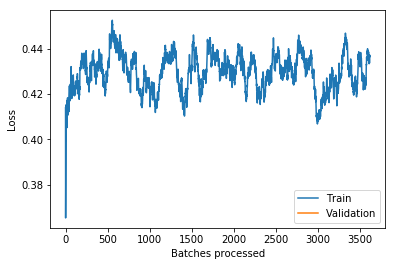

In [22]:
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy_v2', name=f'{model_name}-2')
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4), moms=(0.8, 0.7), callbacks=callbacks); learn.recorder.plot_losses()

In [30]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


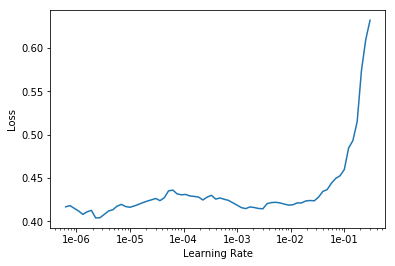

In [31]:
learn.lr_find(); learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_v2,time
0,0.428588,0.422975,0.807640,08:45
1,0.417600,0.416932,0.810088,08:14
2,0.421723,0.418399,0.808417,07:56


Better model found at epoch 0 with accuracy_v2 value: 0.807640016078949.
Better model found at epoch 1 with accuracy_v2 value: 0.8100882172584534.


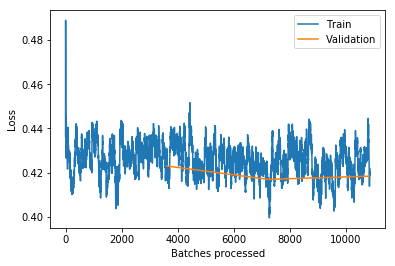

In [32]:
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy_v2', name=f'{model_name}-fitted-a')
learn.fit_one_cycle(3, slice(1e-4/(2.6**4),1e-4), moms=(0.8, 0.7), callbacks=callbacks); learn.recorder.plot_losses()

In [12]:
learn = build_learner(data)
learn.load(f'{model_name}-fitted')

Learner(data=DataBunch;

Train: <swallows.models.EnsembleDataset object at 0x7f0812df0f98>;

Valid: <swallows.models.EnsembleDataset object at 0x7f0806b33048>;

Test: None, model=EnsembleModel(
  (mod_tab): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(348, 42)
      (1): Embedding(8, 5)
      (2): Embedding(39, 12)
      (3): Embedding(6, 4)
      (4): Embedding(847, 70)
      (5): Embedding(5, 4)
      (6): Embedding(3, 3)
      (7): Embedding(407, 46)
      (8): Embedding(1518, 97)
      (9): Embedding(36, 12)
      (10): Embedding(815, 68)
      (11): Embedding(30, 11)
      (12): Embedding(1349, 91)
      (13): Embedding(6, 4)
      (14): Embedding(245, 35)
      (15): Embedding(226, 33)
      (16): Embedding(33, 11)
      (17): Embedding(3, 3)
      (18): Embedding(3, 3)
      (19): Embedding(3, 3)
      (20): Embedding(3, 3)
      (21): Embedding(2, 2)
      (22): Embedding(3, 3)
      (23): Embedding(3, 3)
      (24): Embedding(3, 3)
      (25): Embedding(3, 3)
 

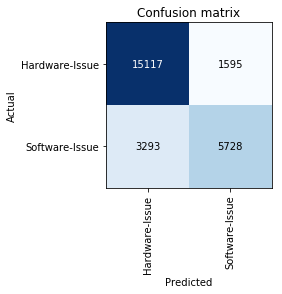

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Predict

In [14]:
df_test = pd.read_parquet(path/'processed/public_test_features_stage_4.parquet', engine='fastparquet')
df_test['has_offline'] = df_test['details'].str.contains('offline')
df_test_ids = pd.read_csv(path/'public_test_features_IDs.csv', low_memory=False)

In [23]:
clas_text_test = pd.DataFrame({'text': df_test['details'] + ' ' +  df_test['short_description']})
data_text.add_test(TextList.from_df(clas_text_test, path, vocab=data_lm.vocab))
data_tab.add_test(TabularList.from_df(df_test[cat_names + cont_names], path=path, cat_names=cat_names, cont_names=cont_names))

In [24]:
data_test = mixed_data_bunch(path, data_text, data_tab, bs)

In [25]:
learn_test = build_learner(data_test)
learn_test.load(f'{model_name}-fitted')

Learner(data=DataBunch;

Train: <swallows.models.EnsembleDataset object at 0x7f0669a06c18>;

Valid: <swallows.models.EnsembleDataset object at 0x7f0669a06a90>;

Test: <swallows.models.EnsembleDataset object at 0x7f0669a06780>, model=EnsembleModel(
  (mod_tab): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(348, 42)
      (1): Embedding(8, 5)
      (2): Embedding(39, 12)
      (3): Embedding(6, 4)
      (4): Embedding(847, 70)
      (5): Embedding(5, 4)
      (6): Embedding(3, 3)
      (7): Embedding(407, 46)
      (8): Embedding(1518, 97)
      (9): Embedding(36, 12)
      (10): Embedding(815, 68)
      (11): Embedding(30, 11)
      (12): Embedding(1349, 91)
      (13): Embedding(6, 4)
      (14): Embedding(245, 35)
      (15): Embedding(226, 33)
      (16): Embedding(33, 11)
      (17): Embedding(3, 3)
      (18): Embedding(3, 3)
      (19): Embedding(3, 3)
      (20): Embedding(3, 3)
      (21): Embedding(2, 2)
      (22): Embedding(3, 3)
      (23): Embedding(3, 3)
   

In [26]:
preds,y = learn_test.get_preds(ds_type=DatasetType.Test)

In [27]:
pred_classes = [data_test.classes[cls] for cls in np.argmax(preds.numpy(), axis=1)]

In [48]:
preds_main = pd.read_csv(path/'mle_ops_tech_2019_05_04_06_40_ensemble-v4-100k.csv', low_memory=False)

In [68]:
df_out = preds_main.join(pd.DataFrame({'ID': df_test_ids['ID'], 'root_cause': pred_classes}), lsuffix='_orig', rsuffix='_hwsw')
df_out['root_cause'] = np.where(df_out['root_cause_orig'].isin(['Hardware-Issue', 'Software-Issue']), df_out['root_cause_hwsw'], df_out['root_cause_orig'])
df_out = df_out.rename(columns={'ID_orig':'ID'})[['ID', 'root_cause']]

In [69]:
t = time.strftime('%Y_%m_%d_%H_%M')
out_fname = path/f'mle_ops_tech_{t}_{model_name}.csv'
df_out.to_csv(out_fname, index=False)
FileLink(out_fname)

/home/ec2-user/2019-ops-it-challenge/data/mle_ops_tech_2019_05_04_22_54_specialist-hw-vs-sw-ensemble-v1.csv